<a href="https://colab.research.google.com/github/jojoroy/Data-Science/blob/main/GPMH_penalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building some intuition about the $L^2$ based risk approach.

The general idea is the following:  we employ a surrogate GP model for the log likelihood of a positive density $\pi$, i.e.
we assume that
$$
    \pi_f(x) = \frac{\exp(f(x))\pi_0(x)}{\int \exp(f(x'))\pi_0(x')\,dx'}.
$$
where $\pi_0$ is a prior distribution which is assumed to be tractable.   We denote by $\widetilde{\pi}_f$ to be the unnormalised posterior distribution.

#### Approach 1:  $L^2$ between unnormalised measures loss.

This is the idea of [Sinsbeck and Nowak](https://epubs.siam.org/doi/abs/10.1137/15M1047659), however it has been adjusted to make it comparable to our approach.  While in their paper they considered a surrogate for the actual forward problem, in this work we surrogate the likelihood directly.   This is directly discussed in [Jarvenpaa et al, 2021](https://projecteuclid.org/journals/bayesian-analysis/volume-16/issue-1/Parallel-Gaussian-Process-Surrogate-Bayesian-Inference-with-Noisy-Likelihood-Evaluations/10.1214/20-BA1200.full), although the focus of that paper is an alternative loss function.   

We wish to derive an optimal estimator for the unnormalised posterior $\widetilde{\pi}_f$ using Bayesian decision theory.  To this end, we consider the integrated quadratic loss function:
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int_{X} |\widetilde{\pi}_1(x) - \widetilde{\pi}_2(x)|^2\,dx,
$$
where we assume that both $\widetilde{\pi}_1$ and $\widetilde{\pi}_2$ are square-integrable.

The optimal bayes estimator is the minimiser of the expected loss, i.e.
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\widetilde{\pi}_f(x) - d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\widetilde{\pi}_f(x) - d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator can be derived and shown to be
$$
    \widetilde{\pi}^* =  \mathbb{E}_{f| D}[\widetilde{\pi}_f].
$$

The Bayes risk is the integrated variance;
$$
\int {Var}_{f | D}[\widetilde{\pi}_f(x)]\,dx.
$$

You can derive closed-form expressions for both in the GP case, namely
$$
   \mathbb{E}_{f| D}[\widetilde{\pi}_f] = \pi_0(x)e^{m(x) + s^2(x)},
$$
and
$$
 {Var}_{f | D}[\widetilde{\pi}_f(x)] = \pi_0(x)^2 e^{2m(x) + s^2(x)}(e^{s^2(x)} - 1),
$$
where $m$ and $s$ are the pointwise mean and standard deviation of the conditioned GP $f | D$.  

#### Approach 2: $L^2$ between the scores.

Ultimately, we want the surrogate model to perform MCMC.  If we're using a gradient based approach, then only really care about the score function, i.e. the gradient of the log likelihood.   It makes sense to consider a loss function which is only penalising errors in the gradient -- this has a lot of advantages:  we no longer have to worry about the normalisation constant, and it simplifies some calculations significantly.

We consider an optimal estimator for the score function $\nabla \log \pi_f$, i.e.
$$
    l(\widetilde{\pi}_1, \widetilde{\pi}_2) = \int |\nabla \log \widetilde{\pi}_1(x) - \nabla \log \widetilde{\pi}_2(x)|^2.
$$
The optimal estimator is then
$$
\begin{aligned}
    \widetilde{\pi}^* &= \arg\min_{d} \mathbb{E}_{f| D} \int |\nabla \log\widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx \\
                      &= \arg\min_{d}  \int \mathbb{E}_{f| D} |\nabla \log \widetilde{\pi}_f(x) - \nabla \log d(x)|^2\,dx
\end{aligned}
$$
The optimal estimator then satisfies
$$
\nabla \log \widetilde{\pi}^*(x) = \nabla \mathbb{E}_{f | D } f(x) = \nabla  m(x),
$$
so that
$$
    \widetilde{\pi}^*(x) \propto e^{m(x)}.
$$
The risk / variance of the estimator is
$$
    \mathbb{E}_{f|D}\int |\nabla \log \pi_f(x) - \nabla m(x)|^2 \,dx =  \mathbb{E}_{f|D}\int |\nabla f(x)- \nabla m(x)|^2 \,dx,
$$
which is
$$
    \int Tr(Cov(\nabla f(x) |D))\,dx = \int \nabla_1 \cdot \nabla_2 k_{D}(x, x)\,dx.
$$
The most important point is that this term is independent of the evaluations of the true posterior.  This means that no active learning is feasible in this instance, and instead we would do a single offline point evaluation stage.


#### Approach 3: Distances between the measures

An alternative approach which constrasts with the local one considered previously, would be to require that the estimator is close to the surrogate in terms of distances on probability distributions.  For example, we could use KL divergence.

Consider
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(d, \pi_f) \\
 &=  \int d(x) \log d(x)\,dx - \int d(x) m_n(x)\,dx,
 \end{aligned}
$$
using the fact that $\int d(x)\,dx = 1$.  This has minimiser:
$$
d^*(x) \propto e^{m_n(x)}
$$

The risk is
$$
\mathbb{E}_{f|D}KL(d^*, \pi_f) = \int\frac{ e^{m_n(x)}}{Z_n}  m_n(x)\,dx - \int \frac{e^{m_n(x)}}{Z_n} m_n(x)\,dx = 0.
$$

(Am I making a mistake here?  This seems unlikely to be true?)

Alternatively, we could consider the Reverse-KL as a loss
$$
\begin{aligned}
 \mathbb{E}_{f|D}l(\pi_f, d) &= \mathbb{E}_{f|D}KL(\pi_f, d) \\
 &=   \mathbb{E}_{f|D}\left[\int \pi_f \log \pi_f\,dx - \int \pi_f \log d(x)\,dx\right], \\
 &=   \int \mathbb{E}_{f|D}[\pi_f \log \pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C +  \int \mathbb{E}_{f|D}[\pi_f] \log \mathbb{E}_{f|D}[\pi_f]\,dx - \int \mathbb{E}_{f|D}[\pi_f] \log d(x) \,dx, \\
 &= C + KL(\mathbb{E}_{f|D}[\pi_f] , d),
 \end{aligned}
$$
where $C$ is a constant.  The optimal estimator is therefore
$$
d^* = \mathbb{E}_{f|D}[\pi_f].
$$

### Our Proposed Approach

We propose the following iterative scheme

Find $p_n$ such that
$$
    \arg\max_{x} \mathbb{E}_{z \sim f(x)|D}\mathbb{E}_{f|D }D(p_{D \cup \lbrace (x,y)\rbrace } \,|\, p_{D})
$$
Choosing KL divergence we have objective function
$$
\mathbb{E}_{z \sim f(x)|D} \mathbb{E}_{f|D }\int \frac{e^{f_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{f_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$

With Fisher divergence, we get a similar expression, but with gradients in the integrand.   If we can argue that we can replace $f$ with it's mean, then this simplifies somewhat:
$$
\mathbb{E}_{z \sim f(x)|D} \int \frac{e^{m_n(x) - k_n(x,x^*)k_n(x^*, x^*)^{-1}z)}}{\int e^{m_n(x') - k_n(x',x^*)k_n(x^*, x^*)^{-1}z)}\,dx'}k_n(x,x^*)k_n(x^*, x^*)^{-1}z\,dx.
$$
It is unclear how we can justify this assumption, and further how to cleanly deal with the expectation wrt to $z$.

### Exploring the $L^2$ loss based estimator and its risk.   

We implement the idea of Sinsbeck and Nowak, but adjust it to work in our setting where we have a surrogate for the likelihood directly.

In [1]:
pip install jaxtyping


In [2]:
pip install gpjax

In [3]:
# Enable Float64 for more stable matrix inversions.
from jax import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

from jax.scipy.special import logsumexp
from jax.scipy.stats import norm as norm
import cola


key = jr.PRNGKey(123)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [4]:
import numpy as np
#from jax.scipy.special import log1p

In [5]:
# Define the function to be sampled from.

# this is the log-likelihood of a Gaussian mixture with means at -2 and 2 and variance 0.1
l = jit(lambda x:  jnp.log(0.5 * jnp.exp(-(x-2)**2/0.2) + 0.5 * jnp.exp(-(x +2)**2/ 0.2)))

xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)
ytest = l(xtest)

D = gpx.Dataset(xtest, ytest)

This is just some test code to check that the Gaussian process does regression properly.

In [6]:
kernel = gpx.kernels.RBF()
meanf = gpx.mean_functions.Zero()
prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)
/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


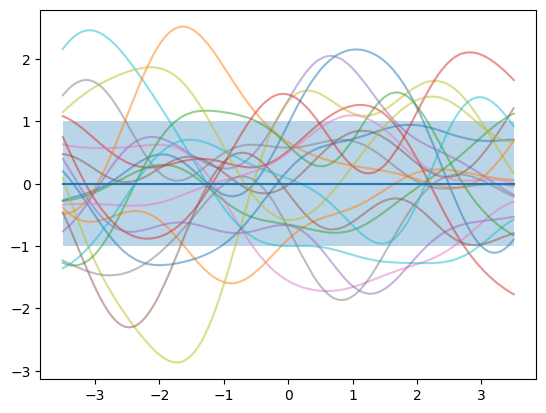

In [7]:
# generate some test points
xtest = jnp.linspace(-3.5, 3.5, 500).reshape(-1, 1)

# predict from the prior
prior_dist = prior.predict(xtest)

# generate samples from the prior and do prediction
prior_mean = prior_dist.mean()
prior_std = prior_dist.variance()
samples = prior_dist.sample(seed=key, sample_shape=(20,))

# plot the prior samples
fig, ax = plt.subplots()
ax.plot(xtest, samples.T, alpha=0.5, label="Prior samples")
ax.plot(xtest, prior_mean,  label="Prior mean")
ax.fill_between(
    xtest.flatten(),
    prior_mean - prior_std,
    prior_mean + prior_std,
    alpha=0.3,
    label="Prior variance",
)
# ax.legend(loc="best")

In [8]:
# Generate the likelihood

likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n)
posterior = prior * likelihood

# Generate the posterior predictive distribution
latent_dist = posterior.predict(xtest, train_data=D)
predictive_dist = posterior.likelihood(latent_dist)

# Extract the mean and variance of the posterior predictive distribution
predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

/usr/local/lib/python3.10/dist-packages/cola/backends/backends.py:75: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(cls, tree_flatten, tree_unflatten)


In [9]:
# Define the negative log marginal likelihood
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll = jit(negative_mll)

def fit_gp(x,y, key, do_optimize=True, obs_stddev=1e-3):
    """Fit a GP to the data (x,y) using the negative log marginal likelihood as the objective function.
    Args:
        x: input data
        y: output data
        key: random key
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        posterior: the posterior distribution
    """

    D = gpx.Dataset(x, y)

    kernel = gpx.kernels.RBF()
    meanf = gpx.mean_functions.Zero()
    prior = gpx.gps.Prior(mean_function=meanf, kernel=kernel)

    likelihood = gpx.likelihoods.Gaussian(num_datapoints=D.n, obs_stddev=obs_stddev)
    posterior = prior * likelihood

    if do_optimize:
        # optimize the hyperparameters using Adam (this isn't great, but it works)
        # TODO: use a better optimizer
        # the optimizer needs optax to work
        opt_posterior, _ = gpx.fit(
        model=posterior,
        objective=negative_mll,
        num_iters=1000,
        train_data=D,
        optim=ox.adamw(learning_rate=0.01),
        key = key)

        return opt_posterior
    else:
        return posterior


def evaluate_posterior(x,y, x_eval, key, do_optimize=True, obs_stddev=1e-3):
    """Evaluate the posterior predictive distribution at x_eval.
    Args:
        x: input data
        y: output data
        x_eval: points at which to evaluate the posterior predictive distribution
        do_optimize: whether to optimize the hyperparameters
        obs_stddev: observation noise
    Returns:
        predictive_mean: mean of the posterior predictive distribution
        predictive_std: standard deviation of the posterior predictive distribution
    """

    D = gpx.Dataset(x, y)

    posterior = fit_gp(x,y, key, do_optimize=do_optimize, obs_stddev=obs_stddev)


    latent_dist = posterior.predict(x_eval, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    predictive_mean = predictive_dist.mean()
    predictive_std = predictive_dist.stddev()

    return predictive_mean, predictive_std

To select a new point, Sinsbeck and Nowak make use of the L2 risk function (also Jarvenpaa et al, 2021), as follows:

$$
    R(\theta^*) = \mathbb{E}_{y \sim f(x^*) |D}\int e^{2m_t(x; x^*, y) + s_t^2(x; x^*, y)}(e^{s_t^2(x; x^*, y)} - 1),
$$
where $m_t(x; x^*, y)$ is the posterior mean of the GP after conditioning on the current data set $D$ along with an additional point $(x^*, y)$.  The variance $s_t^2(x; x^*, y)$ is defined analogously.

To compute the expectation, we do Monte Carlo using exact samples of $y \sim f(x^*) |D$.  We typically use just $10$ samples.  Unsurprisingly this is very slow, and little bit unstable.

To compute the integral over $x$, we evaluate the gp over a fine mesh and use Euler integration.   This obviously cannot scale beyond a few dimensions.

So can we avoid the need to compute the expectation with respect to y?   

To do so, we follow the approach / derivations in [Jarvenpaa, 2021] which derive closed form distributions for the GP mean and GP variance.  

More specifically we can show that the loss function becomes
$$
        R(\theta^*) = \int e^{2m_t(x) + s_t^2(x)}(e^{\tau_t(x, x^*)} - 1),
$$
where
$$
\tau_t(x, x^*) = \frac{k_t(x, x^*)^2}{s_t(x^*)^2 + \sigma^2},
$$
where $\sigma^2$ is the variance of the observational noise and where

* $k_t$ is the kernel (i.e. two-point covariance) of the GP conditioned on $D$.
* $m_t$ is the mean of the GP conditioned on $D$.
* $s_t^2$ is the variance of the GP conditioned on $D$.

In [10]:
# this computes k_t, the two point covariance function
def two_point_covariance(x_current, X, Y, posterior, jitter=1e-6):
    """Compute the two point covariance function.
    Args:
        x_current: current point
        X: input data
        Y: output data
        posterior: posterior distribution
        jitter: jitter for numerical stability
    Returns:
        covariance: two point covariance function
    """
    kernel = posterior.prior.kernel
    obs_noise = posterior.likelihood.obs_stddev**2

    Kxx = kernel.gram(x_current)
    Kxx += cola.ops.I_like(Kxx) * jitter

    #Sigma = Kxx + cola.ops.I_like(Kxx) * obs_noise
    #Sigma = cola.PSD(Sigma)

    KXY = kernel.cross_covariance(X, Y)
    KXx = kernel.cross_covariance(X, x_current)
    KxY = kernel.cross_covariance(x_current, Y)


    Sigma_inv_KxY = cola.solve(Kxx, KxY)

    covariance = KXY - jnp.matmul(KXx, Sigma_inv_KxY)

    return covariance

In [11]:
# Compute the loss function for the next point
def loss_fast(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """

    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean().reshape(-1,1)
    p_std = predictive_dist.stddev().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)

    # compute the tau2 term
    tau2 = C**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    # the log sum exp trick is used to avoid numerical issues.
    # basically this computes
    # log \int e^{2*p_mean + 2*p_std^2} - e^{2*p_mean + p_std^2 + tau2(x^*)} dx
    log_loss = logsumexp(2.0*p_mean + 2.0*p_std**2, axis=0) - logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    return(log_loss)

In [12]:
# This removes the terms that don't depend on x_new
def loss_fast2(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    #latent_dist = posterior.predict(x_grid, train_data=D)
    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    #p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std_new = predictive_dist.stddev()#.reshape(-1,1)

    latent_dist = posterior.predict(x_grid, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)
    p_std = predictive_dist.stddev().reshape(-1,1)
    p_mean = predictive_dist.mean().reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)

    tau2 = C**2/(p_std_new**2 + obs_stddev**2)
    #print(np.shape(tau2))
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)
    print(np.shape(log_loss))
    return(log_loss)

How do we interpret the loss function?

1. The $\mu_n$ weights points which have mean (exploitation)
2. The $\sigma_n^2$ weights points which have higher absolute variance (exploration).
3. The main term $\tau^2(a,b)$ is large when there's a strong correlation between $a$ and $b$, weighted by their standard deviation.

The tau effectively acts as a "bump" function which aggregates points around the design point.

In summary -- preferred design points will lie in a neighbourhood of large $\mu_n$ or large $\sigma^2_n$, thus effectively performing exploration / exploitation.

In [13]:
# Let us test the speed of the new loss function

obs_stddev = 1e-3
num_samples=10

x_grid = jnp.arange(-5.0, 5.0, 0.01).reshape(-1, 1)
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
x_current = jnp.array([[-3.0, 3.0]]).T
y_current = l(x_current)

test_points = jnp.arange(-5.0, 5.0, 0.1)


(100,)


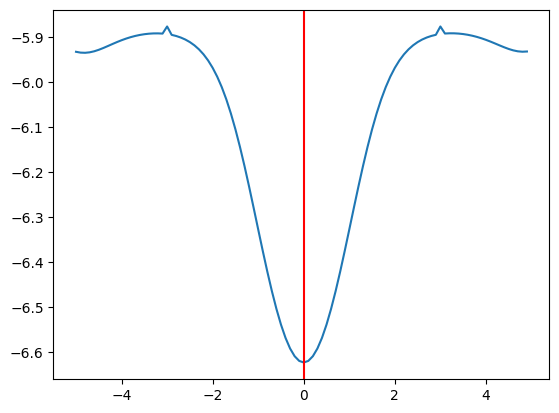

In [14]:
test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
test_point_utilities = loss_fast2(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)

plt.plot(test_points, test_point_utilities)

i = jnp.argmin(jnp.array(test_point_utilities))
x_new = test_points[i]
y_new = l(x_new)
x_current = jnp.vstack([x_current, x_new])
x_current = x_current.sort(axis=0)
y_current =l(x_current)

plt.axvline(x_new, color='red')

# this takes about 2 seconds to run on my M1 Macbook Pro (2020)
# this takes about 2 seconds to run on my M1 Macbook Pro (2020)

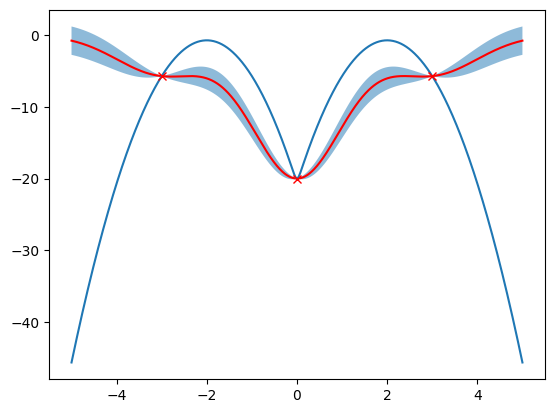

In [15]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)

### Computational Cost

Every macro step of the algorithm is $O(N^3)$, where $N$ is the number of points evaluated
Within each macro-step you have cost $M*N^2$, where $M$ is the number of MCMC samples generated.

# 2023 paper

In [16]:
# This removes the terms that don't depend on x_new
def loss_2023paper(x_current, y_current, x_new, x_grid, key, obs_stddev=1e-3):
    """Evaluate the L2 risk function at x_new.
    The code is vectorised over x_new, so you can just pass in a full grid of test points to evaluate it at

    This version removes the terms that don't depend on x_new, so it's faster than loss_fast.
    Args:
        x_current: input data
        y_current: output data
        x_new: point(s) at which to evaluate the risk function
        x_grid: points at which to evaluate the posterior predictive distribution
        key: random key
        obs_stddev: observation noise
    Returns:
        risk_value: risk function value
    """
    D = gpx.Dataset(x_current, y_current)

    posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

    latent_dist = posterior.predict(x_new, train_data=D)
    predictive_dist = posterior.likelihood(latent_dist)

    p_mean = predictive_dist.mean()#.reshape(-1,1)
    p_std = predictive_dist.stddev()#.reshape(-1,1)

    C = two_point_covariance(x_current, x_grid, x_new, posterior)
    #print(np.shape(C))


    tau2 = (C[0]-C[1])**2/(p_std**2 + obs_stddev**2)
    # utility_value =  jnp.mean(jnp.exp(2.0*p_mean**2 + p_std**2 - offset)*(jnp.exp(p_std**2) - jnp.exp(tau2)), axis=0)

    #log_loss = -logsumexp(2.0*p_mean + p_std**2 + tau2, axis=0)

    #return(log_loss)
    #print(np.shape(tau2))
    return(tau2)

In [17]:
def epsilon_gamma(m,v,u):
  return norm.cdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [18]:
def log_epsilon_gamma(m,v,u):
  return norm.logcdf(-jnp.abs(m-jnp.log(u)/jnp.sqrt(v)))

In [19]:
def log_epsilon_gamma_pen(m,v,u):
  if m-0.5*v**2>u:
    a= 1
  else:
    a=-1
  return norm.logcdf(-a*(m-jnp.log(u))/jnp.sqrt(v))

In [20]:
#PRONE TO INSTABILITY
def expected(m,v):
  if m>=0:
    return norm.cdf(-m/v)-jnp.exp(u+(v**2)/2)*norm.cdf(-(m+v**2)/v)
  else:
    return norm.cdf(m/v)+jnp.exp(u+(v**2)/2)*(norm.cdf(-(m+v**2)/v)-2*norm.cdf(-v))

In [21]:
def expected1(m,v):
  u = jnp.arange(0,1,0.05)
  return logsumexp(log_epsilon_gamma(m,v,u))

In [22]:
#make new eval posterior for this situation
def gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval, train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m[1]-m[0],v[0]**2 + v[1]**2 - 2*C

In [23]:
#make new eval posterior for this situation
def gpmh_eval_posterior2(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(x_eval[1].reshape(-1,1), train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean().reshape(-1,1)
  v = predictive_dist.stddev().reshape(-1,1)
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m,v

In [24]:
def get_it(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C

In [25]:
kernel.gram(x_current)

<3x3 Dense with dtype=float64>

In [ ]:
# define x current and y_current
x_current = jnp.array([[-5., 5.]]).T
y_current = l(x_current)
# set up empty mh_samples
N = 2500
mh_samples=np.zeros(N)
mh_samples[0]=0
epsilon = 0.3
obs_stddev=1e-3
proposal='normal'

Using the whole grid caused more points to be chose

In [ ]:
x_current=x_current.sort(axis=0)

GPMH penalty extension

In [ ]:
# define max_ieter
max_iter= 5
#define test points
x_grid = jnp.arange(-7.5, 7.5, 0.01).reshape(-1, 1)
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
x_current = jnp.array([[-3., 3.0]]).T
y_current = l(x_current)

test_points = jnp.arange(-7.5, 7.5, 0.1)

#def x_grid


In [ ]:
N = 1000
mh_samples=np.zeros(N)
mh_samples[0]=0
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'
errors=np.zeros(N)
qois=np.zeros((N,2))

In [ ]:
m=0
while m < max_iter:
  test_points= jnp.array([testpt for testpt in test_points if testpt not in x_current])
  test_point_utilities = loss_fast2(x_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)



  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  y_new = l(x_new)
  x_current = jnp.vstack([x_current, x_new])
  x_current = x_current.sort(axis=0)
  y_current =l(x_current)


  m+=1

(145,)
(144,)
(143,)
(142,)
(141,)


In [ ]:


D = gpx.Dataset(x_current, y_current)

posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
latent_dist = posterior.predict(mh_samples[0].reshape(-1,1), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean().reshape(-1,1)
v_now = predictive_dist.stddev().reshape(-1,1)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform() - 0.5)*10 + mh_samples[i-1]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior2(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)
  print(m,v,u)
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  qoi = m - v**2
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



ValueError: Inputs, X, and outputs, y, must have the same number of rows. Got X.shape=(6, 1) and y.shape=(45, 1).

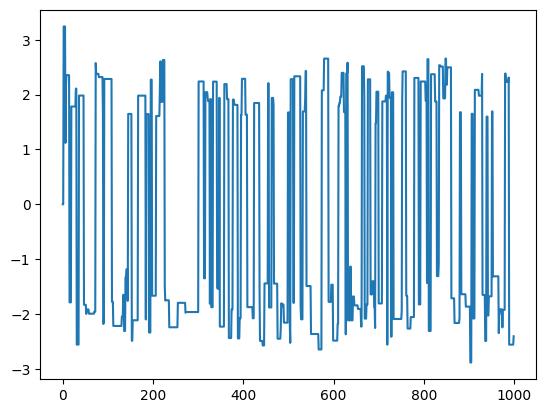

In [ ]:
plt.plot(mh_samples)

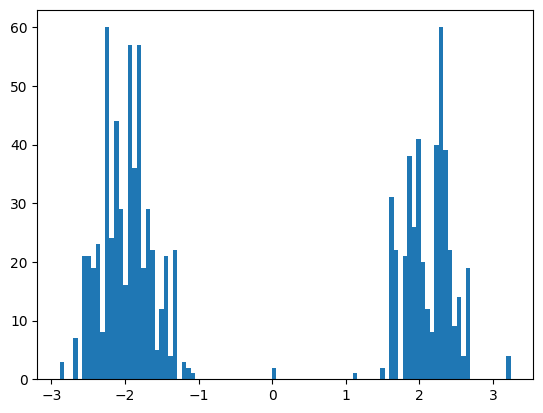

In [ ]:
plt.hist(mh_samples,bins=100)
plt.show()

(-150.0, 10.0)

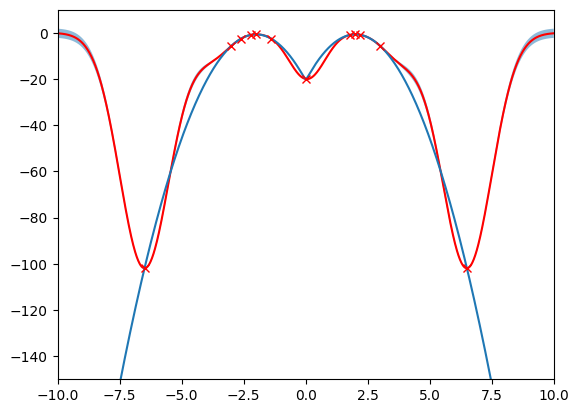

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-10.0, 10.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(x_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),l(xtest))
plt.plot(x_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
plt.xlim(-10,10)
plt.ylim(-150,10)

(array([956.,  12.,   8.,   3.,   1.,   4.,   4.,   5.,   1.,   6.]),
 array([0.        , 0.04743332, 0.09486664, 0.14229997, 0.18973329,
        0.23716661, 0.28459993, 0.33203326, 0.37946658, 0.4268999 ,
        0.47433322]),
 <BarContainer object of 10 artists>)

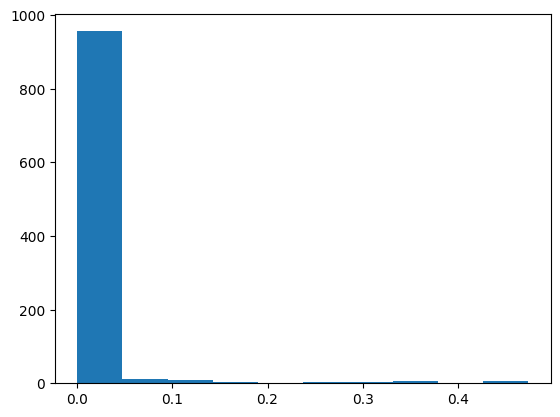

In [ ]:
plt.hist(errors)


In [ ]:
np.where(errors>0.8)

(array([  9,  22,  27,  30,  47,  70,  72,  78,  81,  89,  98, 111, 112,
        133, 134, 139, 153, 163, 172, 192, 197, 203, 207, 213, 222, 226,
        229, 237, 242, 251, 253, 258, 259, 269, 279, 287, 294, 296, 303,
        315, 317, 326, 329, 332, 350, 352, 360, 361, 364, 382, 387, 391,
        392, 394, 398, 402, 406, 413, 419, 426, 432, 433, 436, 444, 456,
        467, 472, 478, 498, 499, 524, 525, 533, 535, 536, 577, 595, 598,
        605, 609, 611, 618, 625, 630, 647, 668, 672, 676, 686, 694, 698,
        700, 707, 710, 712, 715, 729, 746, 750, 753, 757, 773, 775, 777,
        789, 790, 795, 798, 807, 817, 819, 822, 823, 825, 833, 834, 850,
        856, 862, 865, 876, 878, 879, 883, 890, 895, 898, 916, 926, 928,
        937, 940, 943, 950, 955, 965, 966, 968, 984, 985, 986, 987, 991,
        998]),)

## Lotka Volterra

In [26]:
from jax import vmap
from jax.experimental.ode import odeint

In [ ]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha = params
    beta=0.1
    delta=0.1
    gamma=1.5
    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
#@jit
def log_likelihood_lv(params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models
    #with disable_jit():
      #print(errors)
    sigma=5
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array(2.0)
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([1.0,1.1])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-6533.47904685 -6338.88580466]


In [ ]:
# define x current and y_current
params_current = jnp.array([3.0,-1.0])
true_params = jnp.array(2.0)
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current))
# set up empty mh_samples
params_current=params_current.reshape(-1,1)
y_current=y_current.reshape(-1,1)
N = 500
mh_samples=np.zeros((N))
mh_samples[0]=2.5
# define max_ieter
max_iter= 5
#define test points
x_grid = jnp.arange(0, 7.5, 0.01).reshape(-1, 1)
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)

test_points = jnp.arange(0, 7.5, 0.1)
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [ ]:
m=0
while m < max_iter:
  test_points= jnp.array([testpt for testpt in test_points if testpt not in params_current])
  test_point_utilities = loss_fast2(params_current, y_current, test_points.reshape(-1,1), x_grid, key, obs_stddev)



  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  #y_new = log_likelihood_lv(x_new)
  params_current = jnp.vstack([params_current, x_new])
  params_current = params_current.sort(axis=0)
  y_current =log_likelihood_lv(params_current).reshape(-1,1)


  m+=1

(74,)
(73,)
(72,)
(71,)
(70,)


In [ ]:
params_current

Array([[-1. ],
       [ 0.8],
       [ 0.9],
       [ 1.2],
       [ 1.4],
       [ 3. ],
       [ 7.4]], dtype=float64)

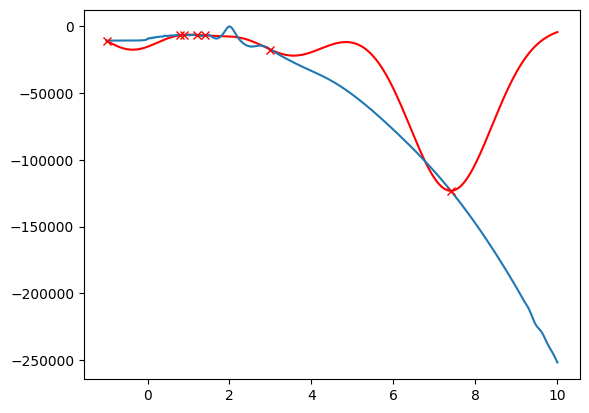

In [ ]:
# x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)
# y_current = l(x_current)

#xtest = jnp.linspace(-5.0, 5.0, 1000).reshape(-1, 1)
xtest = jnp.linspace(-1.0, 10.0, 1000).reshape(-1, 1)

p_mean, p_std = evaluate_posterior(params_current, y_current, xtest,key, do_optimize=False, obs_stddev=obs_stddev)
plt.plot(xtest.squeeze(),p_mean, color='red')
plt.plot(xtest.squeeze(),log_likelihood_lv(xtest))
plt.plot(params_current, y_current, 'x', color='red')

plt.fill_between(
    xtest.squeeze(),
    p_mean - 2 * p_std,
    p_mean + 2 * p_std,
    alpha=0.5,
    label="Two sigma",
)
#plt.xlim(-10,10)
#plt.ylim(-150,10)

In [ ]:


D = gpx.Dataset(params_current, y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
latent_dist = posterior.predict(mh_samples[0].reshape(-1,1), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean().reshape(-1,1)
v_now = predictive_dist.stddev().reshape(-1,1)
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform() - 0.5)*1.5 + mh_samples[i-1]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior2(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)
  print(m,v,u)
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  #errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  qoi = m - v**2
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



step 1 [[0.]] [[0.]] 0.0 Current 2.5 proposed 1.7918681970456263
[[3313.29079685]] [[0.01046343]] 0.22957210066022582
step 2 [[0.]] [[0.]] 0.0 Current 1.7918681970456263 proposed 2.320353394983436
[[-1672.25275198]] [[0.00830253]] 0.0466654252980534
step 3 [[0.]] [[0.]] 0.0 Current 1.7918681970456263 proposed 2.1618671544600576
[[-761.51563436]] [[0.00475649]] 0.04798726202656001
step 4 [[0.]] [[0.]] 0.0 Current 1.7918681970456263 proposed 2.350382621937017
[[-1900.78588878]] [[0.00889135]] 0.7673275683924935
step 5 [[0.]] [[0.]] 0.0 Current 1.7918681970456263 proposed 2.1448625877700187
[[-691.17214164]] [[0.00439063]] 0.20812090646177195
step 6 [[0.]] [[0.]] 0.0 Current 1.7918681970456263 proposed 1.5106657565892865
[[303.14979871]] [[0.00070654]] 0.45995482033077617
step 7 [[0.]] [[0.]] 0.0 Current 1.5106657565892865 proposed 0.7941447993562682
[[315.34840206]] [[2.89239085e-05]] 0.5321203191334966
step 8 [[0.]] [[0.]] 0.002129524766618757 Current 0.7941447993562682 proposed 1.44309

## >=2d

In [27]:
def lotka_volterra(X, t, alpha, beta, delta, gamma):
    x, y = X
    dxdt = alpha * x - beta * x * y
    dydt = delta * x * y - gamma * y
    return [dxdt, dydt]

# Vectorized integration function
def integrate_model(params, t, initial_conditions):
    alpha, beta, delta, gamma = params

    # Define the ODE function for a single set of parameters
    def odefunc(X, t):
        return lotka_volterra(X, t, alpha, beta, delta, gamma)

    # Integrate the ODE
    return odeint(odefunc, initial_conditions, t)

# Vectorized log-likelihood function
@jit
def log_likelihood_lv(log_params):#, t, data, initial_conditions):
    # Ensure params are in the correct shape (N, 4) where N is the number of parameter sets
    params=jnp.exp(log_params)
    def integrate_single(params):
        return integrate_model(params, t, initial_conditions)

    # Vectorize integration over parameter sets
    models = vmap(integrate_single)(params)

    # Compute the error and log-likelihood for each parameter set
    errors = data - models

    sigma=10
    log_likelihoods = -jnp.sum(errors**2, axis=(1, 2)) / (2*sigma**2)
    return log_likelihoods

# Example data
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
data = integrate_model(true_params, t, initial_conditions)

# Initial guess for parameters
initial_params = jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[1.1,1.1,1.1,1.1]])

# Compute log-likelihoods for each parameter set
ll_values = log_likelihood_lv(initial_params)#, t, data, initial_conditions)
print("Log-Likelihoods:", ll_values)

Log-Likelihoods: [-2469.54375493 -2544.23758623 -2527.23380635]


In [32]:
# define x current and y_current
params_current =  jnp.array([[1.0, 0.05,1.0,0.1], [2.0, 0.1,2.0,0.1],[0.1,0.1,0.1,0.1]])
true_params = jnp.array([2.0, 0.1,0.1,1.5])
initial_conditions = jnp.array([10.0, 5.0])
t = jnp.linspace(0, 50, 500)
#data = generate_synthetic_data(true_params, initial_conditions, t)
y_current = jnp.array(log_likelihood_lv(params_current).reshape(-1,1))
# set up empty mh_samples
N = 500
mh_samples=np.zeros((N,4))
mh_samples[0,0]=1.0
mh_samples[0,1]=1.0
mh_samples[0,2]=1.0
mh_samples[0,3]=1.0
# define max_ieter
max_iter= 5
#define test points
x1_range = jnp.arange(start = -3., stop = 3., step = 1.)
x2_range = jnp.arange(start = -3., stop = 3., step = 1.)
x3_range = jnp.arange(start = -3., stop = 3., step = 1.)
x4_range = jnp.arange(start = -3., stop = 3., step = 1.)

x1_gridvalues,x2_gridvalues,x3_gridvalues,x4_gridvalues = jnp.meshgrid(x1_range, x2_range,x3_range,x4_range)
x_grid = jnp.vstack([x1_gridvalues.flatten(), x2_gridvalues.flatten(),x3_gridvalues.flatten(),x4_gridvalues.flatten()]).T
#x_current = jnp.arange(-3.0,3.0, 0.1).reshape(-1, 1)

test_points = x_grid
epsilon = 0.3
obs_stddev=1e-3
proposal='uniform'

In [33]:
m=0
while m < max_iter:
  #test_points= jnp.array([testpt for testpt in test_points if testpt not in params_current])
  test_point_utilities = loss_fast2(params_current, y_current, test_points, x_grid, key, obs_stddev)



  i = jnp.argmin(jnp.array(test_point_utilities))
  x_new = test_points[i]
  #y_new = log_likelihood_lv(x_new)
  params_current = jnp.vstack([params_current, x_new])
  params_current = params_current.sort(axis=0)
  y_current =log_likelihood_lv(params_current).reshape(-1,1)


  m+=1

(1296,)
(1296,)
(1296,)
(1296,)
(1296,)


In [38]:
mh_samples[0]

array([1., 1., 1., 1.])

In [47]:
def gpmh_eval_posterior_2d(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev, D):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval
  #D = gpx.Dataset(x_current, y_current)

  #posterior = fit_gp(x_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)

  latent_dist = posterior.predict(jnp.array([x_eval[1]]), train_data=D)
  predictive_dist = posterior.likelihood(latent_dist)
  m = predictive_dist.mean()
  v = predictive_dist.stddev()
  #C = two_point_covariance(x_current, x_eval[0].reshape(-1,1), x_eval[1].reshape(-1,1), posterior)
  #print(m,x_eval)
  return m,v

In [51]:
def get_it_2d(posterior,x_current,x_prop,x_now,m_now,v_now,key,obs_stddev, D,m,v):
  x_eval = jnp.vstack([x_now,x_prop])

  #x_eval = x_eval.reshape(-1,1)
  C = two_point_covariance(x_current, jnp.array([x_eval[0]]), jnp.array([x_eval[1]]), posterior)
  #print(m,x_eval)
  return m-m_now,v**2 + v_now**2 - 2*C

In [52]:


D = gpx.Dataset(params_current, y_current)

posterior = fit_gp(params_current, y_current, key, do_optimize=False, obs_stddev=obs_stddev)
latent_dist = posterior.predict(jnp.array([mh_samples[0]]), train_data=D)
predictive_dist = posterior.likelihood(latent_dist)
m_now = predictive_dist.mean()
v_now = predictive_dist.stddev()
for i in range(1,N):
  # centred around prev step with var 1
  if proposal == 'uniform':
    x_prop = (np.random.uniform(0,1,4) - 0.5)*1.5 + mh_samples[i-1]
  else:
    x_prop=(np.random.normal()*1 + mh_samples[i-1])
  u = np.random.uniform()
  x_now = mh_samples[i-1]
  # find mean and variance at proposal and prev point
  #m,v = gpmh_eval_posterior(x_current,y_current,x_prop,x_now,key,obs_stddev)
  #m,v = gpmh_eval_posterior1(posterior,x_prop,x_now,key,obs_stddev,D)
  m_prop,v_prop = gpmh_eval_posterior_2d(posterior,x_prop,x_now,m_now,v_now,key,obs_stddev,D)
  m,v=get_it_2d(posterior,params_current,x_prop,x_now,m_now,v_now,key,obs_stddev,D,m_prop,v_prop)
  print('step',i,np.exp(log_epsilon_gamma(m,v,u)),np.exp(log_epsilon_gamma_pen(m,v,u)),jnp.exp(expected1(m,v)),'Current',x_now,'proposed',x_prop)
  print(m,v,u)
  #errors[i-1,0]= jnp.exp(expected1(m,v))
  #errors[i-1]= np.exp(log_epsilon_gamma(m,v,u))
# here implement penalty
  qoi = m - v**2
  if qoi >= jnp.log(u):
    mh_samples[i] = x_prop
    m_now = m_prop
    v_now = v_prop
  else:
    mh_samples[i] = mh_samples[i-1]
  #qois[i-1]=qoi



step 1 [[0.]] [[0.]] 0.0 Current [1. 1. 1. 1.] proposed [0.77792882 1.02630152 0.90300481 1.09249002]
[309.01887461] [[0.05687353]] 0.7106616686322514
step 2 [[0.]] [[0.]] 0.0 Current [0.77792882 1.02630152 0.90300481 1.09249002] proposed [0.91566435 0.59317152 0.83348237 1.39048931]
[245.11157392] [[0.26747926]] 0.2848319091829947
step 3 [[0.]] [[0.]] 0.0 Current [0.91566435 0.59317152 0.83348237 1.39048931] proposed [1.1517746  0.60614567 1.20826257 0.9090383 ]
[-649.96140504] [[0.30114146]] 0.4607944877420258
step 4 [[0.]] [[0.]] 0.0 Current [0.91566435 0.59317152 0.83348237 1.39048931] proposed [1.19791792 0.68604078 0.84095946 0.70545231]
[-947.31723716] [[0.38824381]] 0.7189887709955188
step 5 [[0.]] [[0.]] 0.0 Current [0.91566435 0.59317152 0.83348237 1.39048931] proposed [1.01868389 1.33003564 0.42535679 1.37729248]
[75.54612667] [[0.50360457]] 0.5742962919041773
step 6 [[0.]] [[0.]] 0.0 Current [1.01868389 1.33003564 0.42535679 1.37729248] proposed [1.42279215 1.9449328  0.371